In [1]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 10.1. Long Short-Term Memory (LSTM)

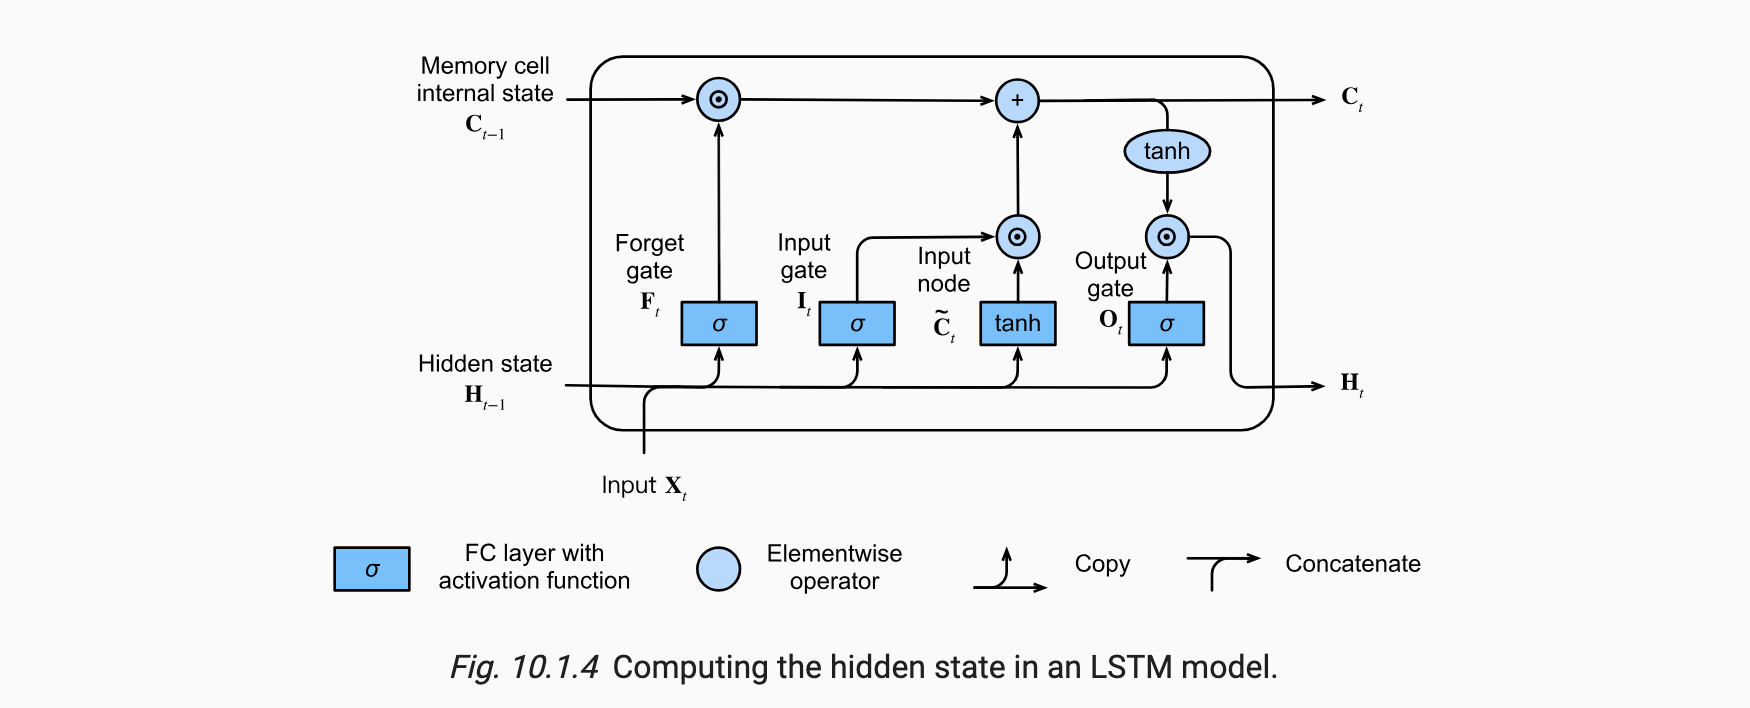

- input gate determines how much of the input node’s value should be added to the current memory cell internal state
    - input gate $I_t$ governs how much we take new data into account via $\tilde{\mathbf{C}}_t$
- forget gate determines whether to keep the current value of the memory or flush it
    -  forget gate $F_t$ addresses how much of the old cell internal state $\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$ we retain
- output gate determines whether the memory cell should influence the output at the current time step
    - when the output gate is close to 1, we allow the memory cell internal state to impact the subsequent layers uninhibited
    - when the output gate values close to 0, we prevent the current memory from impacting other layers of the network at the current time step
- input node $\tilde{\mathbf{C}}_t$
    - use tanh activation function with a value range for $(-1, 1)$
 

## 10.1.2. Implementation from Scratch

In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (
            init_weight(num_inputs, num_hiddens),
            init_weight(num_hiddens, num_hiddens),
            nn.Parameter(torch.zeros(num_hiddens)),
        )
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [3]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(
            torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i
        )
        F = torch.sigmoid(
            torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f
        )
        O = torch.sigmoid(
            torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o
        )
        C_tilde = torch.tanh(
            torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c
        )
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

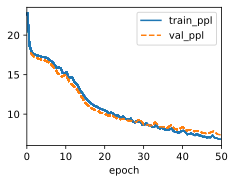

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 10.1.3. Concise Implementation

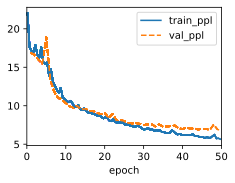

In [5]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)


lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [6]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has and the time travel'

# 10.2. Gated Recurrent Units (GRU)

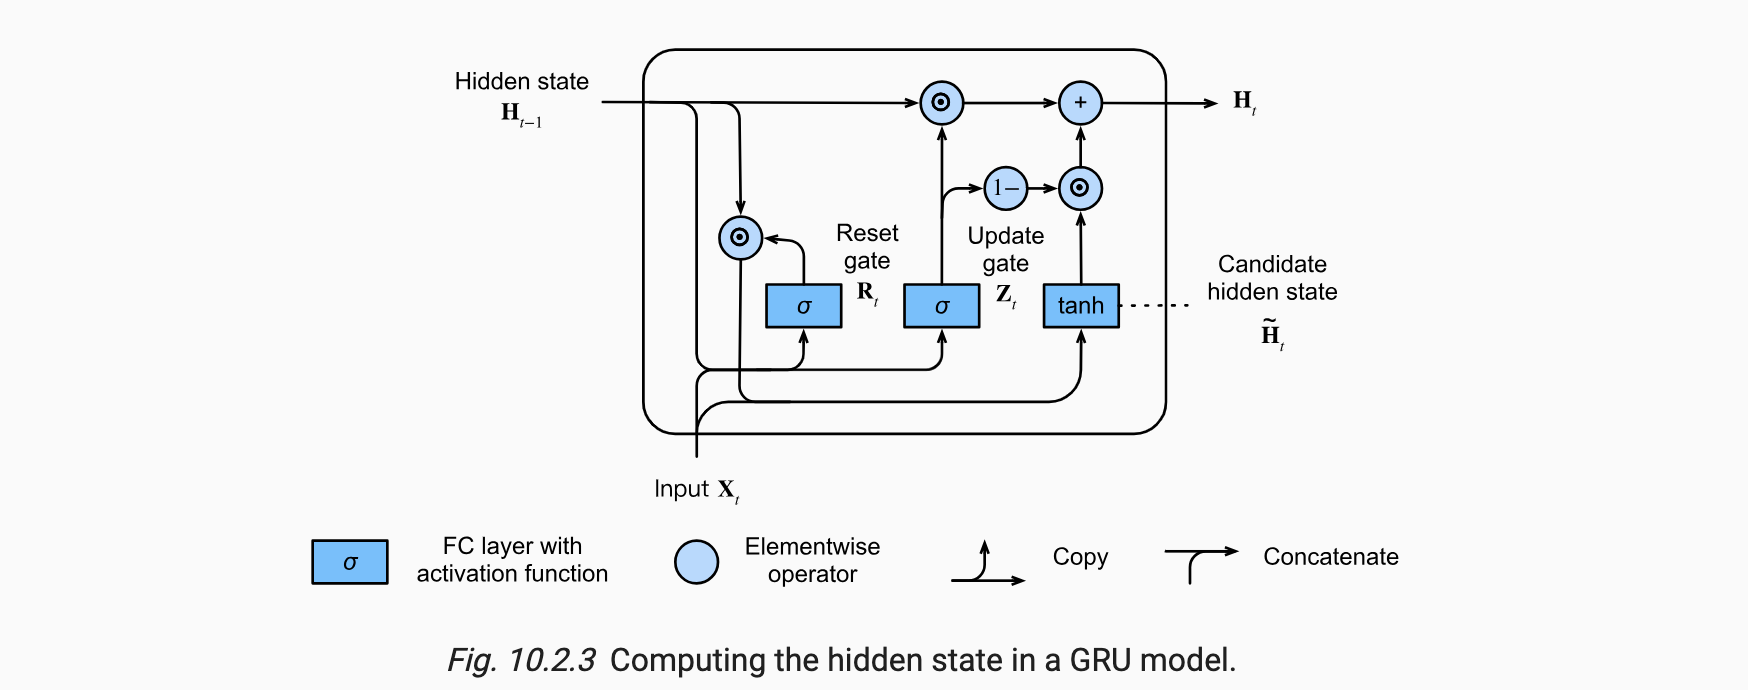

- reset gate controls how much of the previous state we might still want to remember
    - Whenever the entries in the reset gate $R_t$ are close to 1, we recover a vanilla RNN
    - For all entries of the reset gate $R_t$ that are close to 0, the candidate hidden state is the result of an MLP with $X_t$ as input. Any pre-existing hidden state is thus reset to defaults.
- update gate would allow us to control how much of the new state is just a copy of the old one
    - Whenever the update gate $Z_t$ is close to 1, we simply retain the old state.
    - whenever $Z_t$ is close to 0, the new latent state $H_t$ approaches the candidate latent state $\tilde{\mathbf{H}}_t$.
- candidate hidden state $\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step t

## 10.2.4. Implementation from Scratch

In [7]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (
            init_weight(num_inputs, num_hiddens),
            init_weight(num_hiddens, num_hiddens),
            nn.Parameter(torch.zeros(num_hiddens)),
        )
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

In [8]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(
            torch.matmul(X, self.W_xz) + torch.matmul(H, self.W_hz) + self.b_z
        )
        R = torch.sigmoid(
            torch.matmul(X, self.W_xr) + torch.matmul(H, self.W_hr) + self.b_r
        )
        H_tilde = torch.tanh(
            torch.matmul(X, self.W_xh) + torch.matmul(R * H, self.W_hh) + self.b_h
        )
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

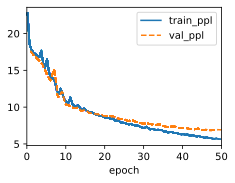

In [9]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 10.2.5. Concise Implementation

In [10]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

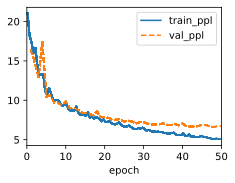

In [11]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [12]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has exist of specal so '

# 10.3. Deep Recurrent Neural Networks

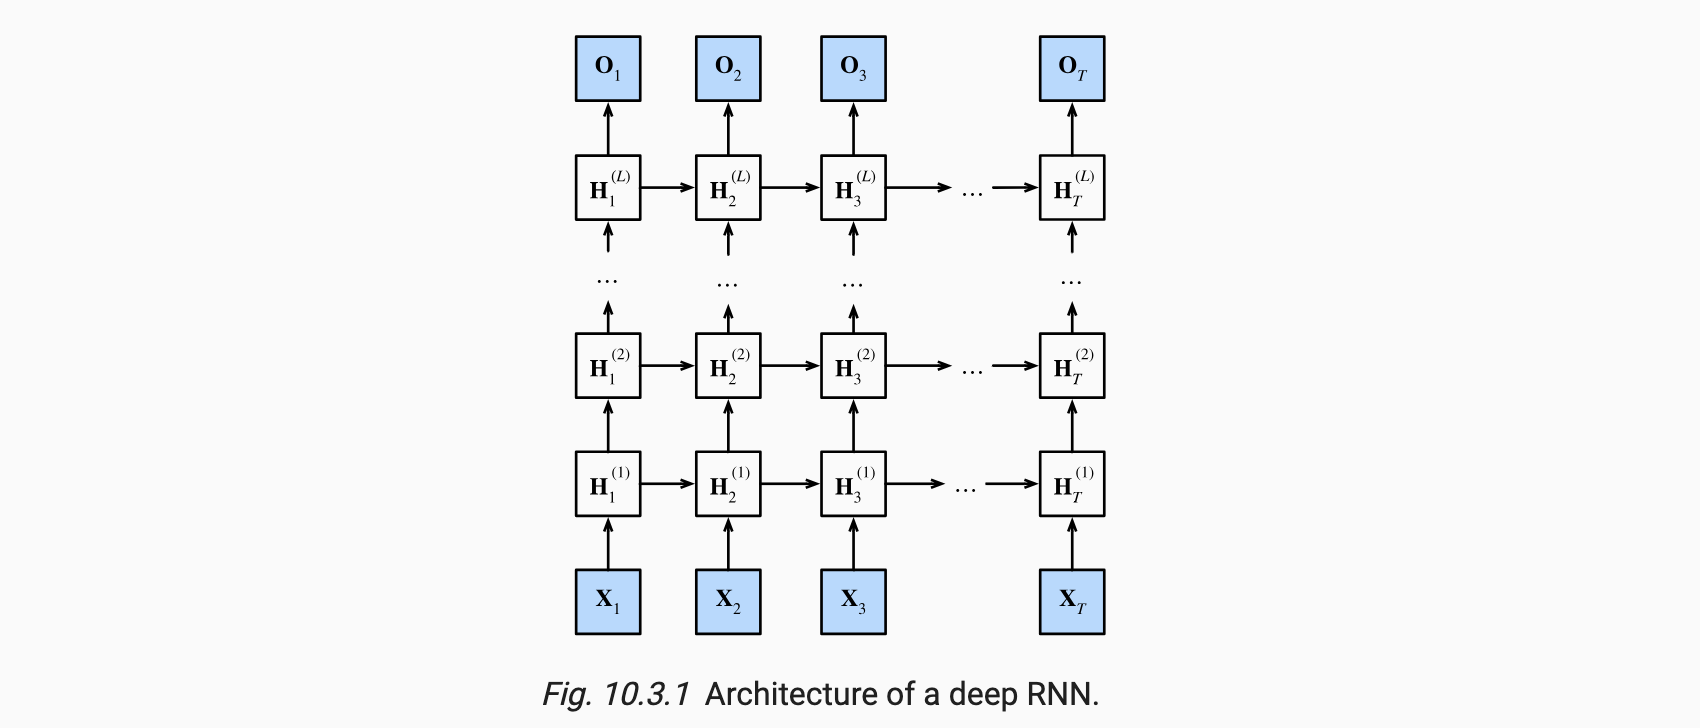

## 10.3.1. Implementation from Scratch

In [13]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(
            *[
                d2l.RNNScratch(
                    num_inputs if i == 0 else num_hiddens, num_hiddens, sigma
                )
                for i in range(num_layers)
            ]
        )

In [14]:
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None:
        Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = torch.stack(outputs, 0)
    return outputs, Hs

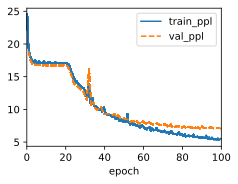

In [15]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 10.3.2. Concise Implementation

In [16]:
class GRU(d2l.RNN):  # @save
    """The multilayer GRU model."""

    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)

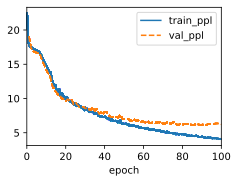

In [17]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [18]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has a man the time trav'

# 10.4. Bidirectional Recurrent Neural Networks

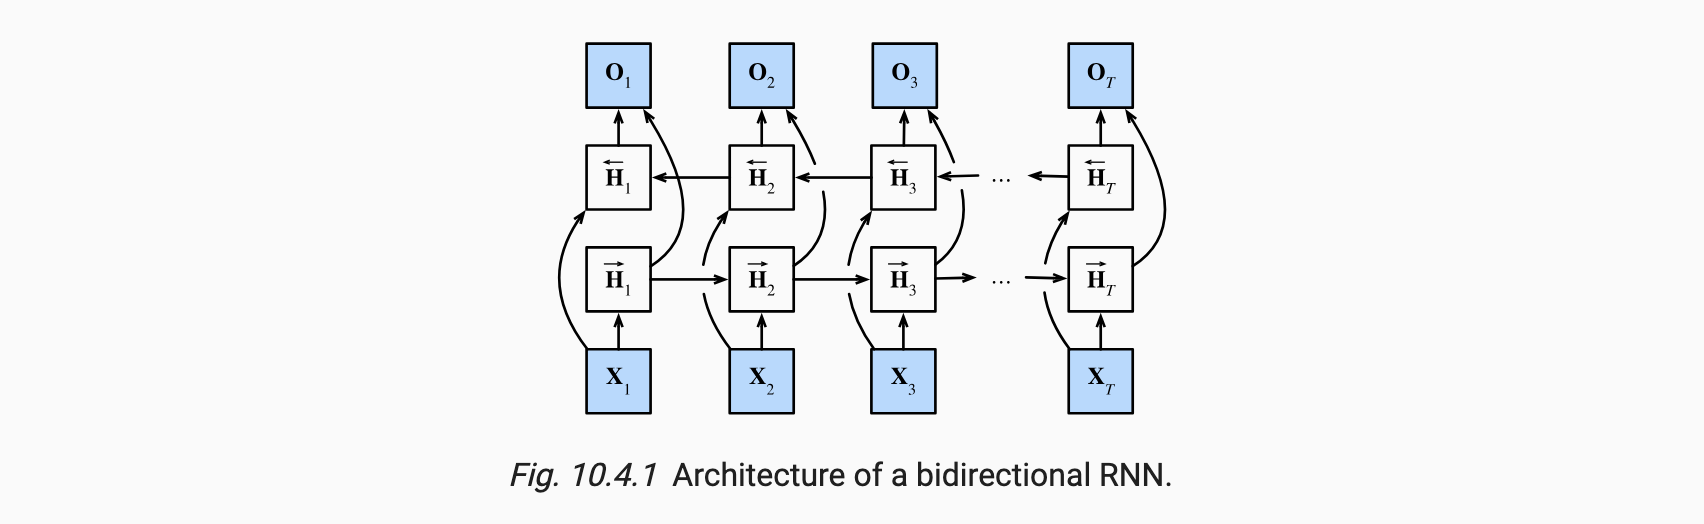

## 10.4.1. Implementation from Scratch

In [19]:
class BiRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.b_rnn = d2l.RNNScratch(num_inputs, num_hiddens, sigma)
        self.num_hiddens *= 2  # The output dimension will be doubled

In [20]:
@d2l.add_to_class(BiRNNScratch)
def forward(self, inputs, Hs=None):
    f_H, b_H = Hs if Hs is not None else (None, None)
    f_outputs, f_H = self.f_rnn(inputs, f_H)
    b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
    outputs = [torch.cat((f, b), -1) for f, b in zip(f_outputs, reversed(b_outputs))]
    return outputs, (f_H, b_H)

## 10.4.2. Concise Implementation

In [21]:
class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

# 10.5. Machine Translation and the Dataset

## 10.5.1. Downloading and Preprocessing the Dataset

download an English–French dataset that consists of bilingual sentence pairs from the Tatoeba Project. Each line in the dataset is a tab-delimited pair consisting of an English text sequence (the source) and the translated French text sequence (the target).

In [22]:
class MTFraEng(d2l.DataModule):  # @save
    """The English-French dataset."""

    def _download(self):
        d2l.extract(
            d2l.download(
                d2l.DATA_URL + "fra-eng.zip",
                self.root,
                "94646ad1522d915e7b0f9296181140edcf86a4f5",
            )
        )
        with open(self.root + "/fra-eng/fra.txt", encoding="utf-8") as f:
            return f.read()


data = MTFraEng()
raw_text = data._download()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



proceed with several preprocessing steps for the raw text data

In [23]:
@d2l.add_to_class(MTFraEng)  # @save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace("\u202f", " ").replace("\xa0", " ")
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ",.!?" and prev_char != " "
    out = [
        " " + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text.lower())
    ]
    return "".join(out)


text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## 10.5.2. Tokenization

prefer word-level tokenization

In [24]:
@d2l.add_to_class(MTFraEng)  # @save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split("\n")):
        if max_examples and i > max_examples:
            break
        parts = line.split("\t")
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f"{parts[0]} <eos>".split(" ") if t])
            tgt.append([t for t in f"{parts[1]} <eos>".split(" ") if t])
    return src, tgt


src, tgt = data._tokenize(text)
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>']])

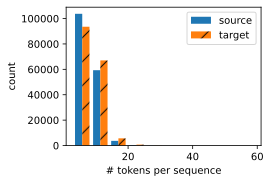

In [25]:
# @save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch("/")
    d2l.plt.legend(legend)


show_list_len_pair_hist(
    ["source", "target"], "# tokens per sequence", "count", src, tgt
)

## 10.5.3. Loading Sequences of Fixed Length

- the special beginning-of-sequence “\<bos\>” token will be used as the first input token for predicting the target sequence  
- If a text sequence has fewer than num_steps tokens, we will keep appending the special “<pad>” token to its end until its length reaches num_steps. Otherwise, we will truncate the text sequence by only taking its first num_steps tokens and discarding the remaining.

In [26]:
@d2l.add_to_class(MTFraEng)  # @save
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())


@d2l.add_to_class(MTFraEng)  # @save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ["<pad>"] * (t - len(seq))
        )
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [["<bos>"] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab["<pad>"]).type(torch.int32).sum(1)
        return array, vocab, valid_len

    src, tgt = self._tokenize(self._preprocess(raw_text), self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return (
        (src_array, tgt_array[:, :-1], src_valid_len, tgt_array[:, 1:]),
        src_vocab,
        tgt_vocab,
    )

## 10.5.4. Reading the Dataset

In [27]:
@d2l.add_to_class(MTFraEng)  # @save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

In [28]:
data = MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print("source:", src.type(torch.int32))
print("decoder input:", tgt.type(torch.int32))
print("source len excluding pad:", src_valid_len.type(torch.int32))
print("label:", label.type(torch.int32))

source: tensor([[ 84,   5,   2,   3,   4,   4,   4,   4,   4],
        [ 92, 115,   2,   3,   4,   4,   4,   4,   4],
        [ 84, 190,   2,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3, 111,   6,   2,   4,   5,   5,   5,   5],
        [  3,  37,   6,   2,   4,   5,   5,   5,   5],
        [  3, 111,  94,   2,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[111,   6,   2,   4,   5,   5,   5,   5,   5],
        [ 37,   6,   2,   4,   5,   5,   5,   5,   5],
        [111,  94,   2,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [29]:
@d2l.add_to_class(MTFraEng)  # @save
def build(self, src_sentences, tgt_sentences):
    raw_text = "\n".join(
        [src + "\t" + tgt for src, tgt in zip(src_sentences, tgt_sentences)]
    )
    arrays, _, _ = self._build_arrays(raw_text, self.src_vocab, self.tgt_vocab)
    return arrays


src, tgt, _, _ = data.build(["hi ."], ["salut ."])
print("source:", data.src_vocab.to_tokens(src[0].type(torch.int32)))
print("target:", data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


# 10.6. The Encoder–Decoder Architecture

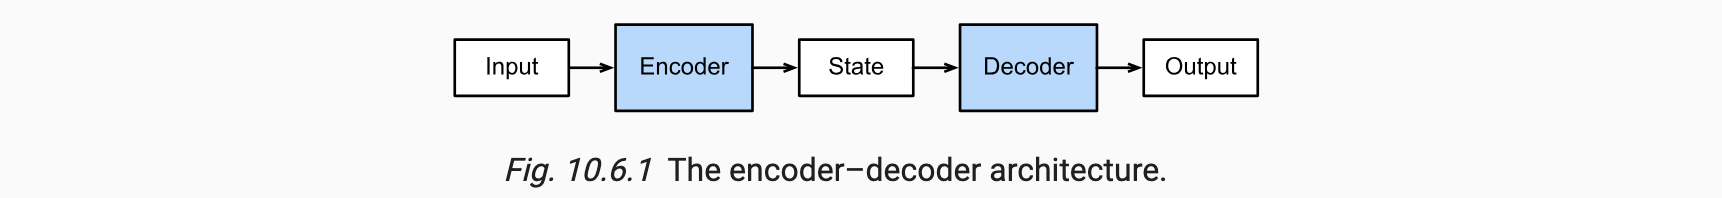

- an encoder that takes a variable-length sequence as input
- a decoder that acts as a conditional language model, taking in the encoded input and the leftwards context of the target sequence and predicting the subsequent token in the target sequence.

## 10.6.1. Encoder

In [30]:
class Encoder(nn.Module):  # @save
    """The base encoder interface for the encoder--decoder architecture."""

    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError

## 10.6.2. Decoder

In [31]:
class Decoder(nn.Module):  # @save
    """The base decoder interface for the encoder--decoder architecture."""

    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

## 10.6.3. Putting the Encoder and Decoder Together

In [32]:
class EncoderDecoder(d2l.Classifier):  # @save
    """The base class for the encoder--decoder architecture."""

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

# 10.7. Sequence-to-Sequence Learning for Machine Translation

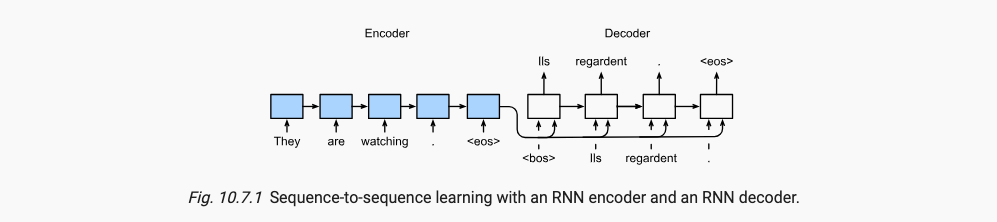

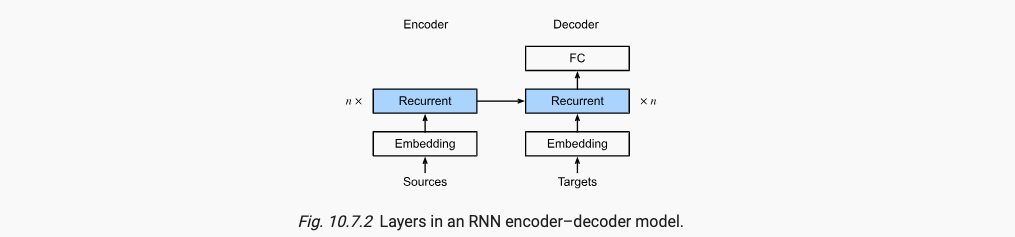

- the special “\<eos\>” token marks the end of the sequence. Our model can stop making predictions once this token is generated
- At the initial time step of the RNN decoder: 
    - begin every input with a special beginning-of-sequence “\<bos\>” token
    - feed the final hidden state of the encoder into the decoder at every single decoding time step

## 10.7.2. Encoder

In [33]:
def init_seq2seq(module):  # @save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])


class Seq2SeqEncoder(d2l.Encoder):  # @save
    """The RNN encoder for sequence-to-sequence learning."""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [34]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

In [35]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

## 10.7.3. Decoder

Given a target output sequence $y_1, y_2, \ldots, y_{T'}$ for each time step $t'$, the decoder assigns a predicted probability to each possible token occurring at step $y_{t'+1}$ conditioned upon the previous tokens in the target $y_1, \ldots, y_{t'}$ and the context variable $\mathbf{c}$, i.e., $P(y_{t'+1} \mid y_1, \ldots, y_{t'}, \mathbf{c})$.

In [36]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""

    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [37]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

## 10.7.4. Encoder–Decoder for Sequence-to-Sequence Learning

In [38]:
class Seq2Seq(d2l.EncoderDecoder):  # @save
    """The RNN encoder--decoder for sequence to sequence learning."""

    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot("loss", self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## 10.7.5. Loss Function with Masking

In [39]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

## 10.7.6. Training

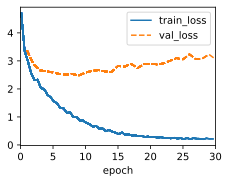

In [40]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout
)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout
)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab["<pad>"], lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 10.7.7. Prediction

In [41]:
@d2l.add_to_class(d2l.EncoderDecoder)  # @save
def predict_step(self, batch, device, num_steps, save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [
        tgt[:, (0)].unsqueeze(1),
    ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

## 10.7.8. Evaluation of Predicted Sequences

$$BLUE = \exp\left(\min\left(0, 1 - \frac{\textrm{len}_{\textrm{label}}}{\textrm{len}_{\textrm{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
where $k$ is the longest n-gram for matching
- whenever the predicted sequence is the same as the target sequence, BLEU is 1
- BLEU assigns a greater weight when a longer n-gram has high precision
- since predicting shorter sequences tends to yield a higher $p_n$ value, the coefficient before the multiplication term penalizes shorter predicted sequences

In [42]:
def bleu(pred_seq, label_seq, k):  # @save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(" "), label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[" ".join(label_tokens[i : i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[" ".join(pred_tokens[i : i + n])] > 0:
                num_matches += 1
                label_subs[" ".join(pred_tokens[i : i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [43]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]
preds, _ = model.predict_step(data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == "<eos>":
            break
        translation.append(token)
    print(f"{en} => {translation}, bleu," f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['soyez', 'calmes', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
